In [1]:
# Importing libraries. 
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm

# To avoid non-essential warnings 
import warnings
warnings.filterwarnings('ignore')

from torchvision import datasets, transforms, models 
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Dataset path. You should change the dataset path to the location that you place the data.
data_dir = 'fruits_dataset'
classes = os.listdir(data_dir)

In [3]:
# Performing Image Transformations. 
train_transform = transforms.Compose([
            transforms.Resize(224),
            transforms.RandomRotation(10),
            transforms.RandomHorizontalFlip(),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize((0.488), (0.2172)),
        ])

In [4]:
# Checking the dataset training size.
dataset = ImageFolder(data_dir, transform=train_transform)
print('Size of training dataset :', len(dataset))

Size of training dataset : 9124


In [5]:
# Viewing one of images shape.
img, label = dataset[100]
print(img.shape)

torch.Size([3, 224, 224])


In [6]:
# Preview one of the images..
def show_image(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  Avocado (2)


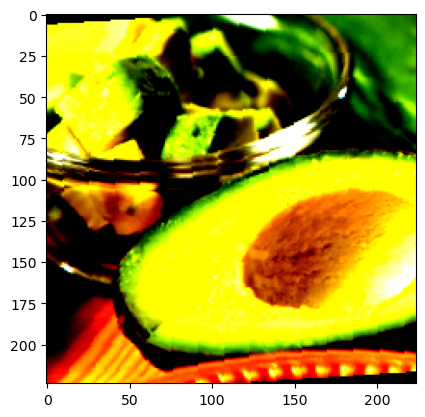

In [7]:
show_image(*dataset[200])

In [8]:
# Setting seed so that value won't change everytime. 
# Splitting the dataset to training, validation, and testing category.
torch.manual_seed(10)
val_size = len(dataset)//20
test_size = len(dataset)//10
train_size = len(dataset) - val_size - test_size

In [9]:
# Random Splitting. 
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
len(train_ds), len(val_ds),len(test_ds)  

(7756, 456, 912)

In [10]:
batch_size = 10
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size, num_workers=2, pin_memory=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


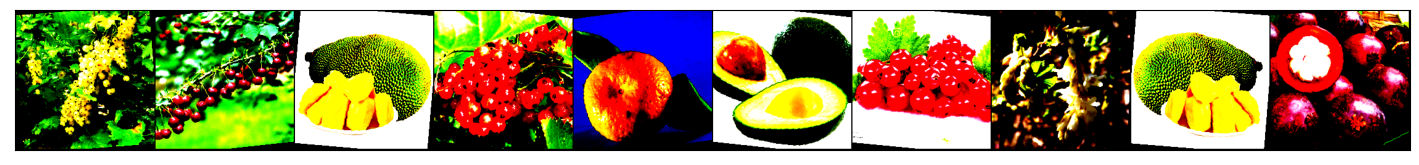

In [11]:
# Multiple images preview. 
for images, labels in train_loader:
    fig, ax = plt.subplots(figsize=(18,10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
    break

In [12]:
 # Baseline model class for training and validation purpose. Evaluation metric function - Accuracy.
def accuracy(output, target, topk=(1,)):
    """
    Computes the accuracy over the k top predictions for the specified values of k
    In top-3 accuracy you give yourself credit for having the right answer
    if the right answer appears in your top five guesses.
    """
    with torch.no_grad():
        maxk = 3
        batch_size = target.size(0)

        # st()
        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = (pred == target.unsqueeze(dim=0)).expand_as(pred)
        correct_3 = correct[:3].reshape(-1).float().sum(0, keepdim=True)
        return correct_3.mul_(1.0 / batch_size)


class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss, Hints: the loss function can be changed to improve the accuracy
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels, (5))           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [13]:
 # To check wether Google Colab GPU has been assigned/not. 

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return None
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [14]:
device = get_default_device()
device
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [15]:
input_size = 3*224*224
output_size = 55

In [16]:
from torchvision.models import resnet18

class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        shape = torch.prod(torch.tensor(x.shape[1:])).item()
        return x.view(-1, shape)


class ConvolutionalNetwork(ImageClassificationBase):
    def __init__(self, classes):
        super().__init__()
        self.classes = nn.Sequential(*list(resnet18(pretrained=True).children())[:-1],Flatten())
        self.fc = nn.Linear(512, 151)
    def forward(self,X):
        X=self.classes(X)
        X=self.fc(X)
        return F.log_softmax(X, dim=1)

In [17]:
# Model print
num_classes = 55
model = ConvolutionalNetwork(num_classes)
#model.cuda()

In [18]:
# We can check the input and the output shape
for images, labels in train_loader:
    out = model(images)
    print('images.shape:', images.shape)    
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([10, 3, 224, 224])
out.shape: torch.Size([10, 151])
out[0]: tensor([-5.1493, -4.2646, -4.9465, -5.7660, -5.7282, -5.1090, -5.2013, -5.6238,
        -3.9052, -5.0071, -5.3152, -5.3964, -5.2788, -3.9987, -4.6302, -4.2872,
        -4.7546, -5.6919, -4.2904, -6.5526, -4.9527, -5.1143, -5.0182, -5.8478,
        -4.9180, -5.3985, -5.1440, -4.8742, -5.9717, -4.8690, -4.8945, -5.4328,
        -5.1945, -6.1924, -5.4696, -5.6837, -5.7884, -4.1477, -5.1978, -5.3857,
        -5.7467, -5.4637, -5.9638, -5.3112, -4.7996, -4.8627, -5.8591, -5.2271,
        -4.4806, -5.9747, -4.1826, -4.8784, -4.7231, -4.0972, -5.8171, -5.2586,
        -5.3868, -5.9524, -5.1299, -6.1624, -4.8790, -4.5880, -4.3522, -5.3648,
        -5.7624, -4.6512, -4.9419, -4.8955, -5.7248, -3.3846, -4.7243, -4.9669,
        -5.1324, -6.2702, -4.0475, -4.2599, -5.2638, -5.0354, -5.3916, -5.4198,
        -4.4804, -4.4382, -5.5424, -5.2576, -5.3011, -4.1898, -4.9951, -5.5470,
        -5.8071, -5.9611, -5.8143, 

In [19]:
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)
to_device(model, device)

ConvolutionalNetwork(
  (classes): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [20]:
# Functions for evaluation and training.

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [21]:
model = to_device(model, device)

In [22]:
history=[evaluate(model, val_loader)]
history

[{'val_loss': 5.270175933837891, 'val_acc': 0.030434785410761833}]

In [23]:
print(test_size)
num_epochs = 25
opt_func = torch.optim.SGD
lr = 0.001

912


In [24]:
history+= fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

  0%|          | 0/776 [00:00<?, ?it/s]

Epoch [0], train_loss: 3.9499, val_loss: 2.9623, val_acc: 0.5688


  0%|          | 0/776 [00:00<?, ?it/s]

Epoch [1], train_loss: 2.6729, val_loss: 2.0303, val_acc: 0.7384


  0%|          | 0/776 [00:00<?, ?it/s]

Epoch [2], train_loss: 2.0147, val_loss: 1.5830, val_acc: 0.7986


  0%|          | 0/776 [00:00<?, ?it/s]

Epoch [3], train_loss: 1.6797, val_loss: 1.3493, val_acc: 0.8486


  0%|          | 0/776 [00:00<?, ?it/s]

Epoch [4], train_loss: 1.4420, val_loss: 1.1992, val_acc: 0.8826


  0%|          | 0/776 [00:00<?, ?it/s]

Epoch [5], train_loss: 1.3072, val_loss: 1.0868, val_acc: 0.8891


  0%|          | 0/776 [00:00<?, ?it/s]

Epoch [6], train_loss: 1.1941, val_loss: 1.0327, val_acc: 0.8935


  0%|          | 0/776 [00:00<?, ?it/s]

Epoch [7], train_loss: 1.0824, val_loss: 0.9648, val_acc: 0.9087


  0%|          | 0/776 [00:00<?, ?it/s]

Epoch [8], train_loss: 1.0075, val_loss: 0.9835, val_acc: 0.8978


  0%|          | 0/776 [00:00<?, ?it/s]

Epoch [9], train_loss: 0.9546, val_loss: 0.9288, val_acc: 0.9043


  0%|          | 0/776 [00:00<?, ?it/s]

Epoch [10], train_loss: 0.8916, val_loss: 0.8951, val_acc: 0.9196


  0%|          | 0/776 [00:00<?, ?it/s]

Epoch [11], train_loss: 0.8468, val_loss: 0.8771, val_acc: 0.9087


  0%|          | 0/776 [00:00<?, ?it/s]

Epoch [12], train_loss: 0.7832, val_loss: 0.8343, val_acc: 0.9217


  0%|          | 0/776 [00:00<?, ?it/s]

Epoch [13], train_loss: 0.7492, val_loss: 0.8371, val_acc: 0.9239


  0%|          | 0/776 [00:00<?, ?it/s]

Epoch [14], train_loss: 0.7176, val_loss: 0.7887, val_acc: 0.9239


  0%|          | 0/776 [00:00<?, ?it/s]

Epoch [15], train_loss: 0.6840, val_loss: 0.7762, val_acc: 0.9239


  0%|          | 0/776 [00:00<?, ?it/s]

Epoch [16], train_loss: 0.6394, val_loss: 0.7752, val_acc: 0.9391


  0%|          | 0/776 [00:00<?, ?it/s]

Epoch [17], train_loss: 0.6197, val_loss: 0.7635, val_acc: 0.9261


  0%|          | 0/776 [00:00<?, ?it/s]

Epoch [18], train_loss: 0.5857, val_loss: 0.7483, val_acc: 0.9304


  0%|          | 0/776 [00:00<?, ?it/s]

Epoch [19], train_loss: 0.5633, val_loss: 0.7646, val_acc: 0.9326


  0%|          | 0/776 [00:00<?, ?it/s]

Epoch [20], train_loss: 0.5421, val_loss: 0.7250, val_acc: 0.9304


  0%|          | 0/776 [00:00<?, ?it/s]

Epoch [21], train_loss: 0.5204, val_loss: 0.7323, val_acc: 0.9370


  0%|          | 0/776 [00:00<?, ?it/s]

Epoch [22], train_loss: 0.4915, val_loss: 0.7193, val_acc: 0.9304


  0%|          | 0/776 [00:00<?, ?it/s]

Epoch [23], train_loss: 0.4651, val_loss: 0.7036, val_acc: 0.9391


  0%|          | 0/776 [00:00<?, ?it/s]

Epoch [24], train_loss: 0.4503, val_loss: 0.7061, val_acc: 0.9413


In [25]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    plt.show()
    
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.show()

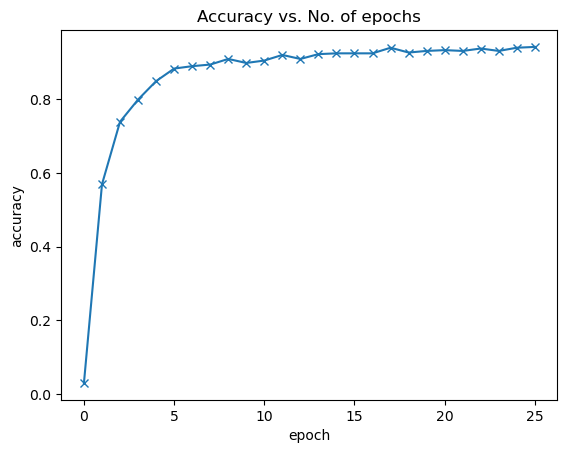

In [26]:
plot_accuracies(history)

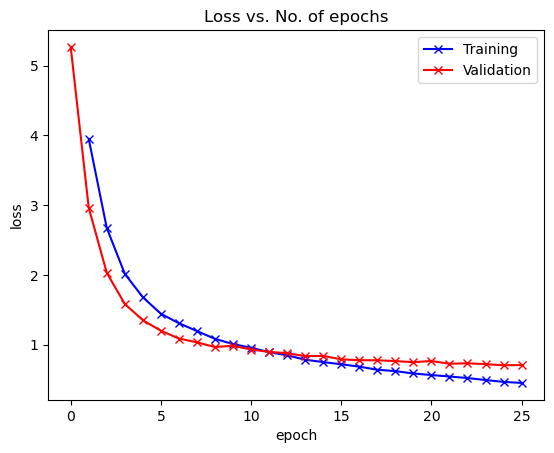

In [27]:
plot_losses(history)

In [28]:
evaluate(model, test_loader)

{'val_loss': 0.5507257580757141, 'val_acc': 0.946739137172699}